# Advanced quantitative techniques - Class 6 - Context for texts

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
files = ['Trump.Inaug.2017', 'Obama.Inaug.2009']
paper_words = {}

for d in files: 
    file_path = 'Data/' + str(d) + '.txt'
    with open(file_path, 'rb') as f:
        f = [f.read().decode('utf8', 'ignore').replace('\r\n', " ").replace('\ufeff', '')]
        paper_words[d] = f

### Collect bigrams

In [3]:
import string
from textblob import TextBlob

bigrams_by_doc = {}
for docid, text in paper_words.items():
    # convert list to string
    text = ' '.join(text)
    
    # to lower case
    text = text.lower()
    
    # remove punctuations
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    
    # get bigrams
    blob = TextBlob(text)
    ngram_var = blob.ngrams(n=2)
    
    bigrams_by_doc[docid] = ngram_var

### Filter out bigrams containing stopwords

In [4]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

bigrams_filtered = {}

# filter out bigrams that contain stopwords
for k, v in bigrams_by_doc.items():
    b = [i for i in v if i[0] not in stop and i[1] not in stop]
    bigrams_filtered[k] = b

### Construct document-term matrix

In [701]:
# count the frequency of each bigram, at the corpus level and at the document level
from collections import Counter

corpus_count = Counter([tuple(b) for v in bigrams_filtered.values() for b in v])

Obama_count = Counter([tuple(b) for b in bigrams_filtered['Obama.Inaug.2009']])
Trump_count = Counter([tuple(b) for b in bigrams_filtered['Trump.Inaug.2017']])

In [702]:
# construct term-document matrix
tdm = pd.DataFrame.from_dict(corpus_count, orient='index', columns=['corpus'])

tdm['Obama'] = pd.Series(Obama_count)
tdm['Trump'] = pd.Series(Trump_count)

tdm.fillna(0, inplace=True)

# document-term matrix
dtm = tdm.T

### Calculate term frequency

In [703]:
tdm['Obama_prop'] = tdm['Obama'].apply(lambda x: x/tdm['Obama'].sum())
tdm['Trump_prop'] = tdm['Trump'].apply(lambda x: x/tdm['Trump'].sum())
tdm['Obama_over_Trump'] = tdm['Obama_prop'] - tdm['Trump_prop']

In [704]:
tdm.reset_index(drop=False, inplace=True)

tdm.rename(columns={'index': 'bigrams'}, inplace=True)

In [705]:
# concatenate bigrams
## a ValueError was encountered possibly due to encoding of the txt files. Added 'try' 'except' in order to bypass this error

for index, bigram in enumerate(tdm.bigrams):
    try:
        e1, e2 = bigram
        tdm.loc[index, 'bigrams_concat'] = str(e1) + ' ' + str(e2)
    except ValueError:
        tdm.loc[index, 'bigrams_concat'] = bigram

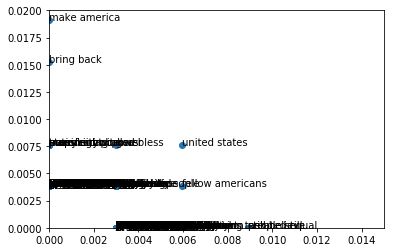

In [706]:
fig, ax = plt.subplots()
plt.scatter(tdm.Obama_prop, tdm.Trump_prop)
plt.xlim(0, 0.015)
plt.ylim(0, 0.02)

for i, txt in enumerate(tdm.bigrams_concat):
    ax.annotate(txt, (tdm.Obama_prop[i], tdm.Trump_prop[i]))

### Most Obama-like bigrams

In [707]:
tdm.sort_values('Obama_over_Trump', ascending=False)[:10]

,bigrams,corpus,Obama,Trump,Obama_prop,Trump_prop,Obama_over_Trump,bigrams_concat
382,"(still, believe)",3,3.0,0.0,0.008929,0.0,0.008929,still believe
381,"(people, still)",3,3.0,0.0,0.008929,0.0,0.008929,people still
266,"(created, equal)",3,3.0,0.0,0.008929,0.0,0.008929,created equal
545,"(let, us)",2,2.0,0.0,0.005952,0.0,0.005952,let us
487,"(generations, task)",2,2.0,0.0,0.005952,0.0,0.005952,generations task
332,"(new, jobs)",2,2.0,0.0,0.005952,0.0,0.005952,new jobs
463,"(compel, us)",2,2.0,0.0,0.005952,0.0,0.005952,compel us
511,"(require, us)",2,2.0,0.0,0.005952,0.0,0.005952,require us
524,"(must, act)",2,2.0,0.0,0.005952,0.0,0.005952,must act
525,"(act, knowing)",2,2.0,0.0,0.005952,0.0,0.005952,act knowing


### Most Trump-like bigrams

In [708]:
tdm.sort_values('Obama_over_Trump')[:10]

,bigrams,corpus,Obama,Trump,Obama_prop,Trump_prop,Obama_over_Trump,bigrams_concat
238,"(make, america)",5,0.0,5.0,0.000000,0.019084,-0.019084,make america
160,"(bring, back)",4,0.0,4.0,0.000000,0.015267,-0.015267,bring back
33,"(transferring, power)",2,0.0,2.0,0.000000,0.007634,-0.007634,transferring power
136,"(every, city)",2,0.0,2.0,0.000000,0.007634,-0.007634,every city
97,"(stops, right)",2,0.0,2.0,0.000000,0.007634,-0.007634,stops right
9,"(president, obama)",2,0.0,2.0,0.000000,0.007634,-0.007634,president obama
40,"(nations, capital)",2,0.0,2.0,0.000000,0.007634,-0.007634,nations capital
129,"(american, workers)",2,0.0,2.0,0.000000,0.007634,-0.007634,american workers
245,"(god, bless)",3,1.0,2.0,0.002976,0.007634,-0.004657,god bless
158,"(winning, like)",1,0.0,1.0,0.000000,0.003817,-0.003817,winning like


### Correlation

In [709]:
tdm[['Obama', 'Trump']].corr(method='pearson')

,Obama,Trump
Obama,1.00000,-0.80065
Trump,-0.80065,1.00000


## Network graphs

In [710]:
# separate bigrams into 'from' and 'to' in order to graph the network
tdm['bigrams_1'] = tdm.bigrams_concat.apply(lambda x: x.split()[0])

# need to add a conditional because the last bigram seems to only contain one word
tdm['bigrams_2'] = tdm.bigrams_concat.apply(lambda x: x.split()[1] if len(x.split())>1 else "")

# filter for bigrams that appear more than once in the corpus
bigram_graph = tdm[tdm.corpus>1].copy()

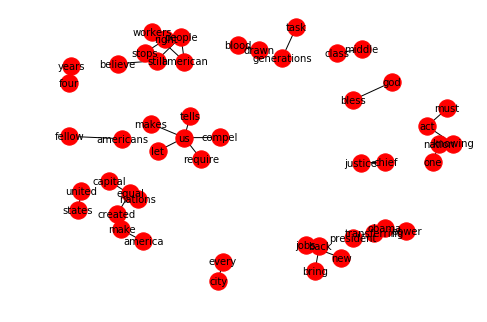

In [711]:
import networkx as nx

G = nx.from_pandas_edgelist(bigram_graph, source='bigrams_1', target='bigrams_2')

nx.draw(G, with_labels=True, font_size=10, pos=nx.spring_layout(G, k=0.35))

## Sentiment analysis - bigrams with negation

In [712]:
# get bigram if the first word of the bigram is 'not' (nested list comprehension)
bigrams_not = [b[0]+ ' ' + b[1] for v in bigrams_by_doc.values() for b in v if b[0]=='not']

# remove duplicated bigrams
bigrams_not = set(bigrams_not)

side note: the above nested list comprehension is equivalent to the following

In [713]:
bigrams_not = []
for v in bigrams_by_doc.values():
    for b in v:
        if b[0]=='not':
            bigrams_not.append(b[0]+ ' ' + b[1])

In [714]:
from afinn import Afinn

afinn = Afinn()
afinn_scores = {b: afinn.score(b) for b in bigrams_not if afinn.score(b) != 0}
afinn_scores

{'not share': 1.0,
 'not fail': -2.0,
 'not fight': -1.0,
 'not succeed': 3.0,
 'not mistake': -2.0}

<BarContainer object of 5 artists>

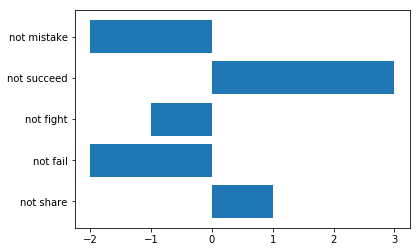

In [715]:
plt.barh(list(afinn_scores.keys()), list(afinn_scores.values()), align='center')

In [716]:
negation_words = ['not', 'no', 'never', 'without']

bigrams_neg = [b[0]+ ' ' + b[1] for v in bigrams_by_doc.values() for b in v if b[0] in negation_words ]
bigrams_neg = set(bigrams_neg)

negated_words = {b: afinn.score(b) for b in bigrams_neg if afinn.score(b) != 0}
negated_words

{'not succeed': 3.0,
 'not fail': -2.0,
 'not share': 1.0,
 'no union': -1.0,
 'no longer': -1.0,
 'never forget': -1.0,
 'no more': -1.0,
 'no room': -1.0,
 'no single': -1.0,
 'not mistake': -2.0,
 'no action': -1.0,
 'not fight': -1.0,
 'no citizen': -1.0,
 'no one': -1.0,
 'no fear': -3.0,
 'no challenge': -2.0}

## Tri-grams

In [816]:
trigrams_by_doc = {}
for docid, text in paper_words.items():
    # convert list to string
    text = ' '.join(text)
    
    # to lower case
    text = text.lower()
    
    # remove punctuations
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    
    # get bigrams
    blob = TextBlob(text)
    ngram_var = blob.ngrams(n=3)
    
    trigrams_by_doc[docid] = ngram_var

In [817]:
trigrams_filtered = {}

# filter out trigrams that contain stopwords
for k, v in trigrams_by_doc.items():
    b = [i for i in v if i[0] not in stop and i[1] not in stop and i[2] not in stop]
    trigrams_filtered[k] = b

In [809]:
corpus_trigram_count = Counter([tuple(b) for v in trigrams_filtered.values() for b in v])
Obama_trigram_count = Counter([tuple(b) for b in trigrams_filtered['Obama.Inaug.2009']])
Trump_trigram_count = Counter([tuple(b) for b in trigrams_filtered['Trump.Inaug.2017']])

In [810]:
# construct term-document matrix
tdm_tri = pd.DataFrame.from_dict(corpus_trigram_count, orient='index', columns=['corpus'])

tdm_tri['Obama'] = pd.Series(Obama_trigram_count)
tdm_tri['Trump'] = pd.Series(Trump_trigram_count)

tdm_tri = tdm_tri.fillna(0)

tdm_tri['Obama_prop'] = tdm_tri['Obama'].apply(lambda x: x/tdm_tri['Obama'].sum())
tdm_tri['Trump_prop'] = tdm_tri['Trump'].apply(lambda x: x/tdm_tri['Trump'].sum())
tdm_tri['Obama_over_Trump'] = tdm_tri['Obama_prop'] - tdm_tri['Trump_prop']

tdm_tri.reset_index(drop=False, inplace=True)
tdm_tri.rename(columns={'index': 'bigrams'}, inplace=True)

In [782]:
tdm_tri.sort_values('Obama_over_Trump', ascending=False)[:10]

,bigrams,corpus,Obama,Trump,Obama_prop,Trump_prop,Obama_over_Trump
149,"(people, still, believe)",3,3.0,0.0,0.030303,0.0,0.030303
181,"(must, act, knowing)",2,2.0,0.0,0.020202,0.0,0.020202
94,"(president, biden, mr)",1,1.0,0.0,0.010101,0.0,0.010101
130,"(world, without, boundaries)",1,1.0,0.0,0.010101,0.0,0.010101
121,"(individual, freedoms, ultimately)",1,1.0,0.0,0.010101,0.0,0.010101
122,"(freedoms, ultimately, requires)",1,1.0,0.0,0.010101,0.0,0.010101
123,"(ultimately, requires, collective)",1,1.0,0.0,0.010101,0.0,0.010101
124,"(requires, collective, action)",1,1.0,0.0,0.010101,0.0,0.010101
125,"(american, soldiers, could)",1,1.0,0.0,0.010101,0.0,0.010101
126,"(science, teachers, well)",1,1.0,0.0,0.010101,0.0,0.010101


In [729]:
tdm_tri.sort_values('Obama_over_Trump')[:10]

,corpus,Obama,Trump,Obama_prop,Trump_prop,Obama_over_Trump
"(chief, justice, roberts)",1,0.0,1.0,0.0,0.010753,-0.010753
"(rules, buy, american)",1,0.0,1.0,0.0,0.010753,-0.010753
"(simple, rules, buy)",1,0.0,1.0,0.0,0.010753,-0.010753
"(two, simple, rules)",1,0.0,1.0,0.0,0.010753,-0.010753
"(follow, two, simple)",1,0.0,1.0,0.0,0.010753,-0.010753
"(build, new, roads)",1,0.0,1.0,0.0,0.010753,-0.010753
"(winning, like, never)",1,0.0,1.0,0.0,0.010753,-0.010753
"(never, ever, let)",1,0.0,1.0,0.0,0.010753,-0.010753
"(benefit, american, workers)",1,0.0,1.0,0.0,0.010753,-0.010753
"(first, every, decision)",1,0.0,1.0,0.0,0.010753,-0.010753


# Topic models - NYT headlines

In [8]:
# slide 68
# using data extracted from the R package
NYT = pd.read_csv('Data/NYTimes.csv')
data = NYT.sample(n=1000, random_state=11)

In [10]:
# perform preprocessing steps on the headlines
from shorttext.utils import standard_text_preprocessor_1
preprocessor1 = standard_text_preprocessor_1()

data['preprocessed_title'] = data.Title.apply(preprocessor1)
data['preprocessed_title'] = data.preprocessed_title.apply(lambda x: x.split())

In [12]:
import gensim

# create dictionary that maps each word to an integer id
dictionary = gensim.corpora.Dictionary(data['preprocessed_title'])

# convert document to bag-of-words format of (token_id, token_count) where token_id corresponds to id in dictionary
bow_corpus = [dictionary.doc2bow(doc) for doc in data.preprocessed_title] 

# train the LDA model with 27 topics
lda_model = gensim.models.LdaModel(bow_corpus, num_topics=27, id2word=dictionary)

**Note: Results here are different from slides due to a different set of randomly selected samples**

In [25]:
# print top 6 words for each topic
for idx, topic in lda_model.print_topics(num_topics=-1, num_words=6):
    print('Topic: {} \nWords: {}'.format(idx+1, topic))

Topic: 1 
Words: 0.014*"drug" + 0.010*"challeng" + 0.010*"rebel" + 0.010*"kill" + 0.010*"file" + 0.010*"us"
Topic: 2 
Words: 0.012*"take" + 0.009*"bush" + 0.009*"polit" + 0.009*"us" + 0.009*"power" + 0.006*"test"
Topic: 3 
Words: 0.012*"mideast" + 0.012*"test" + 0.008*"air" + 0.008*"hope" + 0.008*"presid" + 0.008*"overview"
Topic: 4 
Words: 0.019*"overview" + 0.019*"us" + 0.009*"say" + 0.006*"bomb" + 0.006*"death" + 0.006*"israel"
Topic: 5 
Words: 0.014*"bush" + 0.011*"elect" + 0.007*"hous" + 0.007*"face" + 0.007*"top" + 0.007*"get"
Topic: 6 
Words: 0.020*"us" + 0.012*"campaign" + 0.012*"parti" + 0.008*"pay" + 0.008*"govern" + 0.008*"suspect"
Topic: 7 
Words: 0.022*"us" + 0.013*"clinton" + 0.011*"citi" + 0.009*"new" + 0.009*"rule" + 0.009*"back"
Topic: 8 
Words: 0.026*"new" + 0.012*"presid" + 0.012*"challeng" + 0.012*"terror" + 0.009*"nation" + 0.009*"seek"
Topic: 9 
Words: 0.007*"tax" + 0.007*"tribun" + 0.007*"seek" + 0.007*"overview" + 0.007*"tortur" + 0.007*"bill"
Topic: 10 
Words: 

In [40]:
# for each document, get the topic assigned by LdaModel
data['lda_topic'] = data['preprocessed_title'].apply(lambda x: lda_model[dictionary.doc2bow(x)][0][0])

In [59]:
pd.options.display.max_colwidth = 110

In [53]:
# display a sample of 5 headlines classified as topic 1 by LdaModel
data.loc[data.lda_topic==1, 'Title'].sample(5, random_state=11)

2223                                              PALESTINIAN MOB ATTACKS POLLSTER
73      POLITICS: IN CONGRESS; The Speaker's Gruff No. 2 Takes Charge in the House
2341                                 Bush Signs Law To Cover Drugs For the Elderly
2383         Mayor Joins Mourners at Funeral for Teenager Killed by Police Officer
2048                                 Lott Apologizes Again on Words About '48 Race
Name: Title, dtype: object

In [60]:
data.loc[data.lda_topic==3, 'Title'].sample(5, random_state=11)

3080                                                                                A Kick, a Push and a Quick Escape
1669    U.S. VS. Microsoft: The Overview; U.S. Abandoning Its Efforts To Break Apart Microsoft, Saying It Seeks Re...
1501                                                             U.S. Is Beginning Criminal Inquiry In Pardon Of Rich
729                                                                          Schumer Racing D'Amato for Campaign Cash
2617                                                That Line at the Ferrari Dealer? It's Bonus Season on Wall Street
Name: Title, dtype: object

## Topic models - Amazon reviews

For an example involving over 20k Amazon reviews, check out this ipynb: https://gist.github.com/kevindavenport/d704e37e9f9d175303b1eb083f8e749e#file-topic_modeling_amazon_reviews-ipynb

# Adverbs

In [2]:
sou = pd.read_csv('Data/sou-texts.csv', error_bad_lines=False)
presidents = pd.read_csv('Data/presidents - Sheet1.csv')

b'Skipping line 233: expected 5 fields, saw 300\n'


In [3]:
presidents.set_index('president', inplace=True)

# append party affiliation
sou = sou.join(presidents, on=['president'])

In [4]:
# import adverbs
POS = pd.read_csv('Data/SUBTLEX_PoS.csv')

POS2 = POS[POS.pos=='Adverb']

# make a list of the adverbs
adverbs = [w for w in POS2.word]

In [5]:
# keep the columns that we need
sou = sou[['president', 'date', 'text', 'party']].copy()

# lower case the speeches
sou['text'] = sou['text'].apply(lambda x: x.lower())

# tokenize the speeches
from nltk.tokenize import word_tokenize
sou['tokens'] = sou['text'].apply(lambda x: word_tokenize(x))

In [6]:
# get list of adverbs for each speech
sou['adverbs'] = sou['tokens'].apply(lambda x: [w for w in x if w in adverbs])

### Graph adverb usage trend

In [7]:
# calculate proportion of adverbs in each speech
sou['speech_len'] = sou['tokens'].apply(lambda x: len(x))
sou['n_adverbs'] = sou['adverbs'].apply(lambda x: len(x))
sou['prop_adverbs'] = sou.n_adverbs/sou.speech_len

Text(0,0.5,'proportion of adverbs')

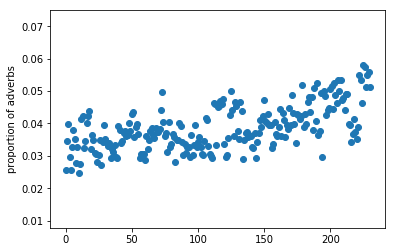

In [152]:
plt.scatter(sou.index, sou['prop_adverbs'])
plt.ylabel('proportion of adverbs')

### Most common adverbs overall

In [153]:
adverb_count = Counter()

for doc in sou['adverbs']:
    adverb_count.update(doc)

adverb_count.most_common(20)

[('so', 3881),
 ('now', 3343),
 ('only', 2468),
 ('most', 2332),
 ('also', 1844),
 ('over', 1574),
 ('out', 1425),
 ('well', 1419),
 ('very', 1265),
 ('just', 1239),
 ('right', 1190),
 ('where', 1084),
 ('up', 1082),
 ('still', 1071),
 ('far', 1071),
 ('long', 1004),
 ('already', 968),
 ('yet', 956),
 ('even', 936),
 ('less', 930)]

### Common adverbs in early SOUs

In [78]:
early_sous = sou[sou.index<120].copy()

early_adverbs = Counter()
for doc in early_sous['adverbs']:
    early_adverbs.update(doc)
    
early_adverbs.most_common(20)

[('so', 2431),
 ('now', 1683),
 ('only', 1523),
 ('most', 1462),
 ('also', 923),
 ('well', 866),
 ('over', 785),
 ('thus', 736),
 ('far', 736),
 ('very', 689),
 ('however', 678),
 ('out', 670),
 ('just', 667),
 ('right', 654),
 ('yet', 654),
 ('less', 634),
 ('still', 578),
 ('where', 577),
 ('long', 567),
 ('already', 559)]

### Common adverbs in late SOUs

In [79]:
late_sous = sou[sou.index>120].copy()

late_adverbs = Counter()
for doc in late_sous['adverbs']:
    late_adverbs.update(doc)
    
late_adverbs.most_common(20)

[('now', 1634),
 ('so', 1423),
 ('only', 931),
 ('also', 904),
 ('most', 854),
 ('over', 783),
 ('out', 740),
 ('up', 666),
 ('just', 569),
 ('very', 565),
 ('well', 540),
 ('together', 535),
 ('right', 535),
 ('today', 527),
 ('tonight', 523),
 ('better', 518),
 ('here', 513),
 ('where', 499),
 ('still', 489),
 ('home', 452)]

## Adverbs ending in -ly

In [35]:
bing = pd.read_csv('Data/bing.csv')
bing_words = list(bing.word)

In [64]:
# get words that are in bing
sou['sentiment_words'] = sou['tokens'].apply(lambda x: [w for w in x if w in bing_words])

In [65]:
# get adverbs that are in bing and end in -ly
sou['words_ly'] = sou['sentiment_words'].apply(lambda x: [w for w in x if w.endswith("ly")])

In [75]:
# calculate number of adverbs that end in -ly
sou['n_words_ly'] = sou['words_ly'].apply(lambda x: len(x))

sou['prop_words_ly'] = sou.n_words_ly/sou.n_adverbs

Text(0,0.5,'adverbs ending in -ly out of all words')

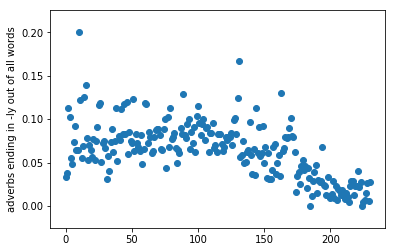

In [76]:
plt.scatter(sou.index, sou['prop_words_ly'])
plt.ylabel('adverbs ending in -ly out of all adverbs')

In [68]:
adverb_ly_count = Counter()

for doc in sou['words_ly']:
    adverb_ly_count.update(doc)

adverb_ly_count.most_common(20)

[('friendly', 448),
 ('earnestly', 282),
 ('promptly', 234),
 ('clearly', 182),
 ('properly', 177),
 ('successfully', 137),
 ('justly', 128),
 ('wisely', 109),
 ('effectively', 106),
 ('scarcely', 104),
 ('speedily', 101),
 ('fairly', 99),
 ('happily', 94),
 ('sufficiently', 91),
 ('respectfully', 90),
 ('safely', 82),
 ('unfortunately', 79),
 ('readily', 76),
 ('faithfully', 76),
 ('inevitably', 76)]

In [81]:
early_ly_adverbs = Counter()
for doc in early_sous['words_ly']:
    early_ly_adverbs.update(doc)
    
early_ly_adverbs.most_common(20)

[('friendly', 389),
 ('earnestly', 223),
 ('promptly', 148),
 ('properly', 121),
 ('justly', 119),
 ('scarcely', 100),
 ('clearly', 91),
 ('speedily', 87),
 ('respectfully', 82),
 ('happily', 78),
 ('successfully', 77),
 ('sufficiently', 72),
 ('faithfully', 68),
 ('fairly', 67),
 ('wisely', 65),
 ('readily', 62),
 ('safely', 62),
 ('peculiarly', 50),
 ('reasonably', 50),
 ('unfortunately', 50)]

In [82]:
late_ly_adverbs = Counter()
for doc in late_sous['words_ly']:
    late_ly_adverbs.update(doc)
    
late_ly_adverbs.most_common(20)

[('clearly', 90),
 ('promptly', 84),
 ('effectively', 64),
 ('successfully', 60),
 ('friendly', 57),
 ('earnestly', 53),
 ('properly', 51),
 ('orderly', 44),
 ('wisely', 44),
 ('costly', 43),
 ('fairly', 32),
 ('unfortunately', 29),
 ('inevitably', 25),
 ('exceedingly', 23),
 ('slowly', 20),
 ('safely', 20),
 ('deadly', 20),
 ('sufficiently', 19),
 ('reasonably', 17),
 ('consistently', 17)]